# Generative Adversarial Network to learn 1-d Gaussian

In [1]:

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from scipy.stats import norm
import matplotlib.pyplot as plt

Function to generate samples from Uniform [-1,1] for  input for generator

In [25]:

def sample_noise(M):
    z = np.float32(np.linspace(-1.0, 1.0, M) + np.random.random(M) * 0.01)
    return z

In [26]:
sample_noise(10)

array([-0.9990471 , -0.77495086, -0.55181324, -0.32554168, -0.10625939,
        0.11724818,  0.33571607,  0.560866  ,  0.7828145 ,  1.0070225 ],
      dtype=float32)

## Function to plot metrics

In [36]:

def plot_fig(generate, discriminate):
    xs = np.linspace(-5, 5, 1000)
    plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')

    r = 100
    xs = np.float32(np.linspace(-3, 3, r))
    xs_tensor = Variable(torch.from_numpy(xs.reshape(r, 1)))
    ds_tensor = discriminate(xs_tensor)
    ds = ds_tensor.data.numpy()
    plt.plot(xs, ds, label='decision boundary')

    n=1000
    zs = sample_noise(n)
    plt.hist(zs, bins=20, density=True, label='noise')
    zs_tensor = Variable(torch.from_numpy(np.float32(zs.reshape(n, 1))))
    gs_tensor = generate(zs_tensor)
    gs = gs_tensor.data.numpy()
    plt.hist(gs, bins=20, density=True, label='generated')
    plt.plot(xs, norm.pdf(xs, loc=np.mean(gs), scale=np.std(gs)), label='generated_dist')
    plt.legend()
    plt.xlim(-3,3)
    plt.ylim(0,5)
    plt.show()

# Generator

In [37]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.l1 = nn.Linear(1, 10)
        self.l1_relu = nn.ReLU()
        self.l2 = nn.Linear(10, 10)
        self.l2_relu = nn.ReLU()
        self.l3 = nn.Linear(10, 1)

    def forward(self, input):
        output = self.l1(input)
        output = self.l1_relu(output)
        output = self.l2(output)
        output = self.l2_relu(output)
        output = self.l3(output)
        return output

# Discriminator 

In [38]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.l1 = nn.Linear(1, 10)
        self.l1_tanh = nn.Tanh()
        self.l2 = nn.Linear(10, 10)
        self.l2_tanh = nn.Tanh()
        self.l3 = nn.Linear(10, 1)
        self.l3_sigmoid = nn.Sigmoid()

    def forward(self, input):
        output = self.l1_tanh(self.l1(input))
        output = self.l2_tanh(self.l2(output))
        output = self.l3_sigmoid(self.l3(output))
        return output

For generator,
$$minimize  -log(D(G(z)))$$
For discriminator,
$$minimize -{log(1-D(G(z))) + log(D(true))}$$

In [92]:
def generator_criterion(d_output_g):
    return -0.5 * torch.mean(torch.log(d_output_g))


def discriminator_criterion(d_output_true, d_output_g):
    return -0.5 * torch.mean(torch.log(d_output_true) + torch.log(1-d_output_g))

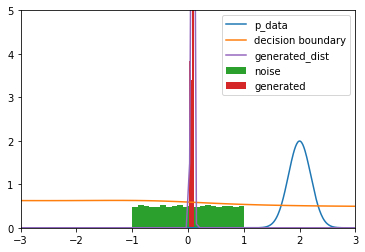

In [107]:

mu = 2
sigma = 0.2

#minibatch size
M = 200   

discriminate = Discriminator()
generate = Generator()

plot_fig(generate, discriminate)

epochs = 500
histd, histg = np.zeros(epochs), np.zeros(epochs)

#discriminator updated k times per one update of generator
k = 20



# Training

_._ Higher Learning rate for discriminator
_._ Discriminator updated k=20 times per update of generator

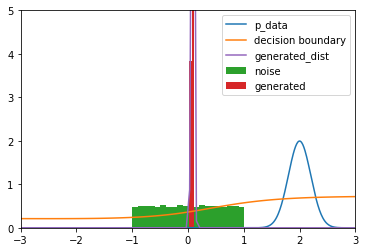

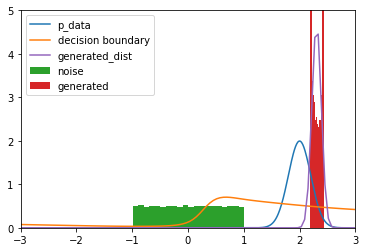

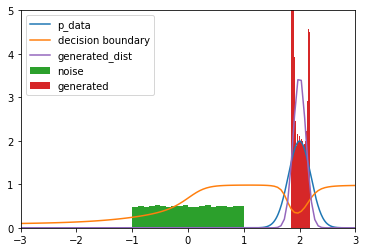

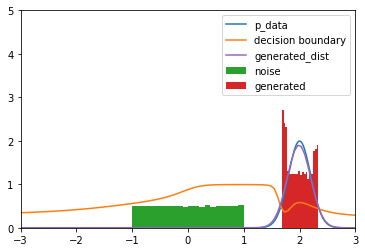

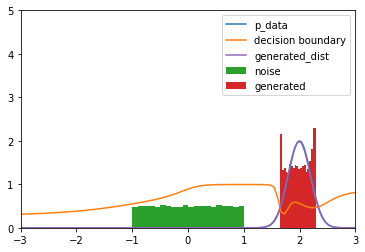

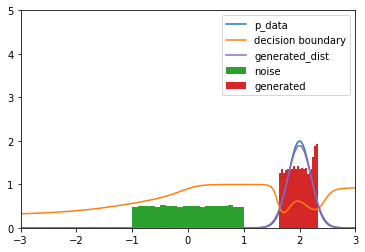

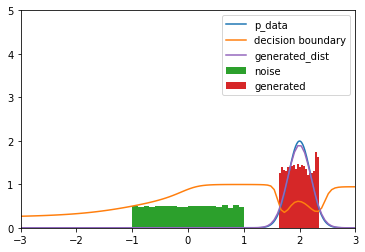

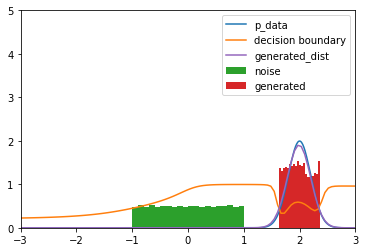

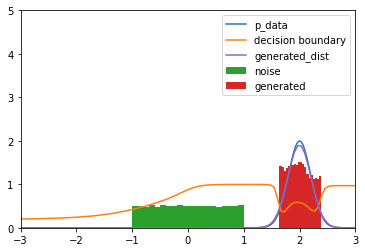

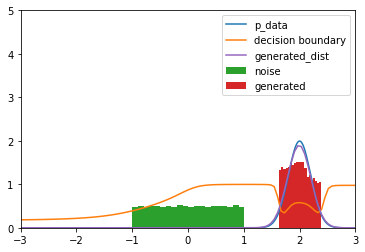

<Figure size 432x288 with 0 Axes>

In [108]:
discriminate_optimizer = torch.optim.SGD(discriminate.parameters(), lr=0.1, momentum=0.6)
generate_optimizer = torch.optim.SGD(generate.parameters(), lr=0.01, momentum=0.6)

for i in range(epochs):
    for j in range(k):
        discriminate.zero_grad()
        x = np.float32(np.random.normal(mu, sigma, M))
        z = sample_noise(M)
        z_tensor = Variable(torch.from_numpy(np.float32(z.reshape(M, 1))))
        x_tensor = Variable(torch.from_numpy(np.float32(x.reshape(M, 1))))
        g_out = generate(z_tensor)
        d_out_true = discriminate(x_tensor)
        d_out_g = discriminate(g_out)
        loss = discriminator_criterion(d_out_true, d_out_g)
        loss.backward()
        discriminate_optimizer.step()
        histd[i] = loss.data.numpy()

    generate.zero_grad()
    z = sample_noise(M)
    z_tensor = Variable(torch.from_numpy(np.float32(z.reshape(M, 1))))
    g_out = generate(z_tensor)
    d_out_g = discriminate(g_out)
    loss = generator_criterion(d_out_g)
    loss.backward()
    generate_optimizer.step()
    histg[i] = loss.data.numpy()

    if i % 10 == 0:
        for param_group in generate_optimizer.param_groups:
            param_group['lr'] *= 0.999
        for param_group in discriminate_optimizer.param_groups:
            param_group['lr'] *= 0.999

    if i % 50 == 0:
        #print('Discriminator loss', histd[i])
        #print('Generator loss', histg[i])
        plt.clf()
        plot_fig(generate, discriminate)
        plt.draw()



# Loss Convergence 

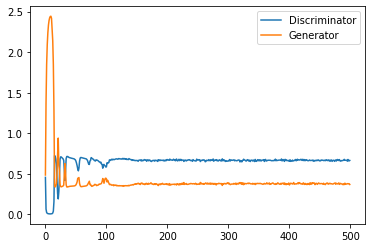

In [109]:
plt.plot(range(epochs), histd, label='Discriminator')
plt.plot(range(epochs), histg, label='Generator')
plt.legend()
plt.show()

# After training

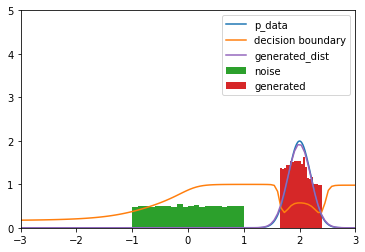

In [110]:

plot_fig(generate, discriminate)
plt.show()